# Moving From Spark to Visualizations.
In the last post, we reviewed some data cleaning and how to use Apache spark. We're going to move on to visualizations; while I like the data tables and numbers, when showing the conclusions to others then visualizations are the way to go. Numbers without context are meaningless and the reason they mean something to the individual making the analysis is that you have the data as context. But, those you're showing the conclusinos too do not - and they didn't spend hours cleaning and thinking about the data like you did.

In [367]:
#| include: false
sc.stop()

In [ ]:
#| include: false

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Conf for config; context spark "cluster"
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local[*]").setAppName("play")
sc = SparkContext(conf = conf)
sc.setLogLevel("ERROR")

# session to talk to the "cluster"
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("play").getOrCreate()

from pyspark.sql.types import *

# collect the ability to define udfs
import pyspark.sql.functions as F

We'll add all the cleaning from before just for that context I was talking about; I would recommending seeing the part one of this series if your curious about that process.

In [4]:
# Define the schema:
shows = StructType([
    StructField('Ignore', IntegerType(), True),
    StructField('Name', StringType(), True),
    StructField('Year', StringType(), True),
    StructField('Guide', StringType(), True),
    StructField('Duration', StringType(), True),
    StructField('Genres', StringType(), True),
    StructField('Ratings', FloatType(), True),
    StructField('Actors', StringType(), True),
    StructField('Votes', StringType(), True),
])

data = spark.read.csv(
    str(Path(
        '_data',
        'AllThrillerSeriesListClean.csv')),
        header=True,
    schema=shows)

In [5]:
# Cleanup
data = data.drop('Ignore')

data = data.withColumn('isOngoing',     # Target this column
    F.udf(                              # define a udf
        lambda x: x.strip()[-1] == '–') # use the logic we already wrote.
    ('Year')                            # pass the column we're applying this to.
)

data = data.withColumn('startYear', F.udf( lambda x: x.split('–')[0])('Year'))
data = data.withColumn('Votes', F.udf( lambda x: int(x.replace(',', '')))('Votes'))
data = data.withColumn('Votes', F.cast(IntegerType(), data['Votes']))

data = data.withColumn('Genre', F.split(data['Genres'], ','))
data = data.withColumn('Genre', F.explode(data['Genre']))

data = data.withColumn('Actor', F.split(data['Actors'], ','))
data = data.withColumn('Actor', F.explode(data['Actor']))

# Gotta clean up the inputs:
data = data.withColumn('Genre', F.udf(lambda x: x.strip())('Genre'))
data = data.withColumn('Actor', F.udf(lambda x: x.strip())('Actor'))
data = data.withColumn('Votes', F.udf( lambda x: int(x) )('Votes'))

cData = data.select(
    ['Name', 'Year', 'Guide', 
    'Duration', 'Ratings', 'Votes', 
    'isOngoing', 'startYear', 'Genre', 'Actor']
)

cData.show(10)

+-----+------+------+--------+-------+-----+---------+---------+---------+------------------+
| Name|  Year| Guide|Duration|Ratings|Votes|isOngoing|startYear|    Genre|             Actor|
+-----+------+------+--------+-------+-----+---------+---------+---------+------------------+
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|   Action|        Diego Luna|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|   Action|       Kyle Soller|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|   Action| Stellan Skarsgård|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|   Action|Genevieve O'Reilly|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|Adventure|        Diego Luna|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|Adventure|       Kyle Soller|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|Adventure| Stellan Skarsgård|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2

# Let's Start Asking Some Questions. 
Looking at the data we have, we'll be asking:
1. Are the numeric columns Normally Distributed?
2. What is the Distribution of Ratings for the top Genres?
3. How does a show's Ongoing status affect it's ratings?

## QQ plot of Numeric Values
A **Quantile-Quantile Plot** is a plot which takes the data and compares it against commonly another distribution. While it is less well known, it is most commonly used as a visual indicator of whether a dataset is Normally Distributed. Since matplotlib and seaborn don't have this built in we'll need to use a different library this time: statsmodels.

In [1]:
import numpy as np
import statsmodels.api as sm
import pylab as py

To plot the data we'll need to pull it out of Spark and convert it to pandas; we've done this enough at this point. But, we've never used the sql api like this before. I quite like this interface since SQL queries are simply to read.

In [9]:
# To use this, we'll need what is called a View; this is an idea from SQL
cData.createOrReplaceTempView("TMP")
tmp = spark.sql("SELECT Ratings,Duration,Votes FROM TMP WHERE Duration IS NOT NULL")
tmp = tmp.withColumn('nDuration', F.udf( lambda x: x.replace(' min', '').replace(',', ''))('Duration'))

qqData = tmp.select(['Ratings', 'nDuration', 'Votes']).toPandas()
qqData

,Ratings,nDuration,Votes
0,8.4,40,82474
1,8.4,40,82474
2,8.4,40,82474
3,8.4,40,82474
4,8.4,40,82474
...,...,...,...
26228,6.4,45,25
26229,6.4,45,25
26230,6.4,45,25
26231,6.4,45,25


### Are Ratings Normally Distributed?
Now we'll check if the Ratings are *Normally Distributed*.

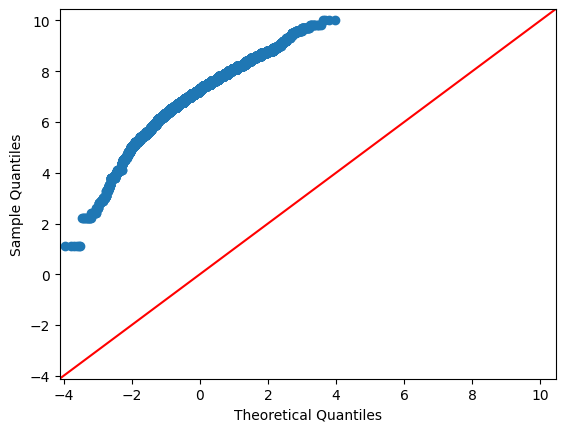

In [11]:
# Add the the y=x line for comparison.
sm.qqplot(qqData.Ratings, line ='45')
plt.show()
#py.show()

From the above, this is not a normally distributed dataset. When we have situations like this, it is not uncommon to try a log tranform if the data does not fit. The reason for this is that taking the logarithmic of the data maintains the underlying mathematical relationship. So, let's try it!

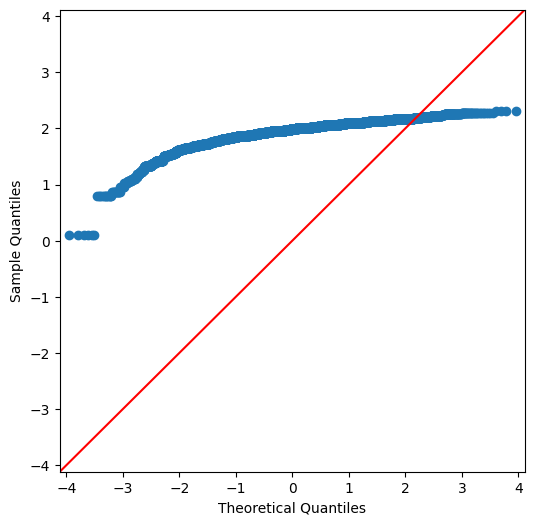

In [21]:
plt.rcParams["figure.figsize"] = (6,6)
sm.qqplot(np.log(qqData.Ratings), line ='45')
plt.show()

Still No. We'll want to avoid any model which has linear prerequisites.

### Is Duration Normally Distributed?
The duration of a show is very likely to not be normally distributed. The length is not random and there are very few posssible choices. But, we're going to check anyways.

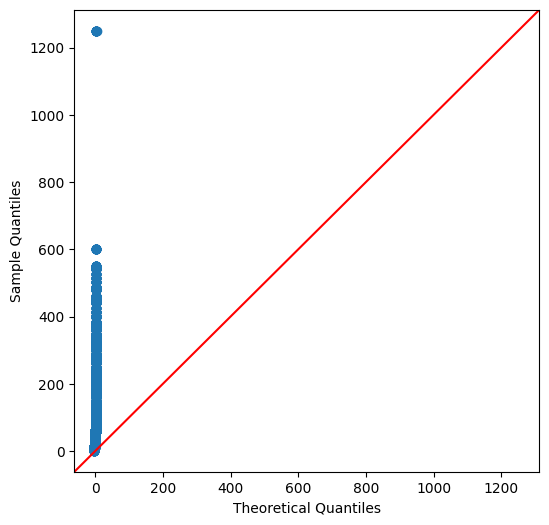

In [22]:
plt.rcParams["figure.figsize"] = (6,6)
sm.qqplot(qqData.nDuration.astype(int), line ='45')
plt.show()

And, expected no.

### Are Votes Normally Distributed?
We would expect votes to be normally distributed as this is the kind of process where as you would select samples it should approach normal.

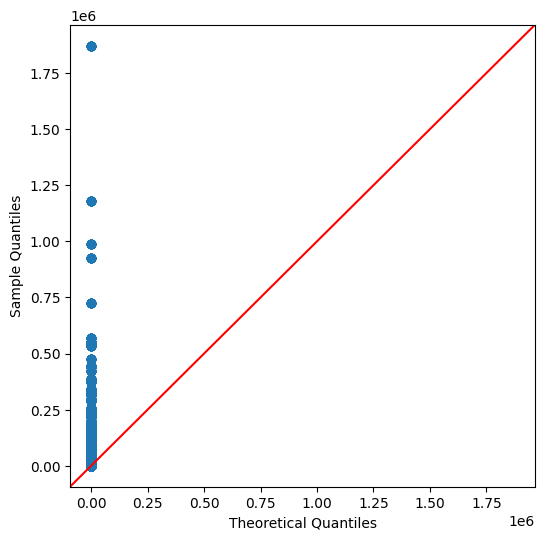

In [25]:
plt.rcParams["figure.figsize"] = (6,6)
sm.qqplot(qqData.Votes.astype(int), line ='45')
plt.show()

Still even this is not normally distributed. This is starting to get worrying because at least this would be expected to be normally distributed.

## Ridge Plot of Genre Ratings
Looking at the distribution of numeric variables can be useful. Normally, we could do a *Distribution Plot* or a *Histogram* to visualize this. But, I thought I would do something more interesting: a **Ridge Plot**. So, a *Ridge Plot* shows the distribution of values but conditioned on a category. And, we're going to use it to check the ratings for the top categories and how they break down. First we'll need to get our data.

In [377]:
from pyspark.sql.functions import mean as sMean, col

# Use results from previous post:
results = cData.select(['Genre', 'Ratings', 'Votes']).groupBy('Genre').agg(
    sMean('Ratings').alias("Mean"),
    sMean('Votes').alias('Votes')
    ).orderBy(F.desc("Mean")).toPandas()

results.head(10)

,Genre,Mean,Votes
0,Biography,7.795238,33137.952381
1,Music,7.475000,413.625000
2,History,7.416667,3330.541667
3,Animation,7.270712,8447.388742
4,Fantasy,7.231312,18573.573756
5,Adventure,7.228473,8999.588235
6,Crime,7.225607,15978.954034
7,Comedy,7.223730,4206.774311
8,Family,7.207407,635.759259
9,Drama,7.203856,17351.695414


We'll make a new SQL View with Apache Spark to filter out the top Genres.

In [378]:
cData.createOrReplaceTempView("Explore")
# Using our results, collect the categories to filter for.
values = ','.join([f"'{x}'" for x in results.head(8).Genre.tolist()])

ridgeSlice = spark.sql(f"SELECT Genre,Ratings FROM Explore WHERE Genre IN( { values } )").toPandas()

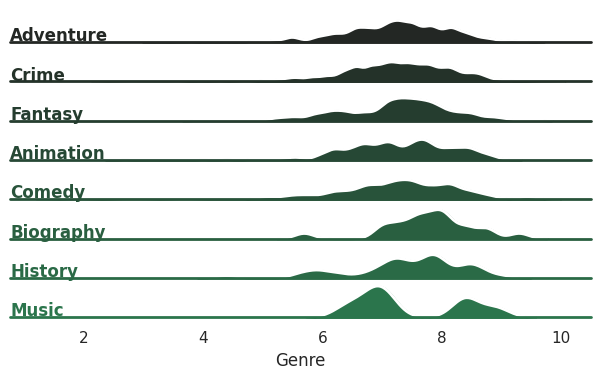

In [385]:
# This is just to stop some spam.
import warnings
warnings.filterwarnings("ignore")


# Theming:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.dark_palette("seagreen", n_colors=10)

plt.rcParams["figure.figsize"] = (14,7)
g = sns.FacetGrid(ridgeSlice, row="Genre", hue="Genre", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Ratings",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Ratings", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Genre")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True);

Music quickly stands out; people either like or dislike the show and there is little in between. Fantasy and Biography are clumped a little under 8 but mostly concentrated. The others are closer to what we'd expect from a normal distribution. Comedy, Animation and History are interesting since there is more spread among the ratings

## JointPlot

A *Joinplot* is a nicer looking scatterplot. It includes some of the same information but also you can add distibution information. Personally, I like the *Hexagons* so we're going to use those. And, we're going to see how the year affects the Rating over time.

In [391]:
try:
    results = cData.select(['startYear', 'Ratings']).toPandas()
    results = results.assign(
        Year = results.startYear.astype(int)
    )
    results.head(15)
except Exception as e:
    print( e )

invalid literal for int() with base 10: 's2018'


Uh oh, looks like we've got some more cleaning to do. Let's look at what is affected and see how widespread this is.

In [392]:
results.loc[ results.startYear == 's2018']

,startYear,Ratings
24638,s2018,6.1
24639,s2018,6.1
24640,s2018,6.1
24641,s2018,6.1
24642,s2018,6.1
24643,s2018,6.1
24644,s2018,6.1
24645,s2018,6.1
24646,s2018,6.1
24647,s2018,6.1


This might be the same movie/show which is being exploded out. We're going to just fix it for our analysis at this point. Again, if we were getting this data from a Data Engineer then we'd want to discuss this with them to clean this upstream. 

In [393]:
results['startYear'] = results.startYear.str.replace('s2018', '2018')
results = results.assign(
    Year = results.startYear.astype(int)
)
results.head(15)

,startYear,Ratings,Year
0,2022,8.4,2022
1,2022,8.4,2022
2,2022,8.4,2022
3,2022,8.4,2022
4,2022,8.4,2022
5,2022,8.4,2022
6,2022,8.4,2022
7,2022,8.4,2022
8,2022,8.4,2022
9,2022,8.4,2022


So, let's see the Data!

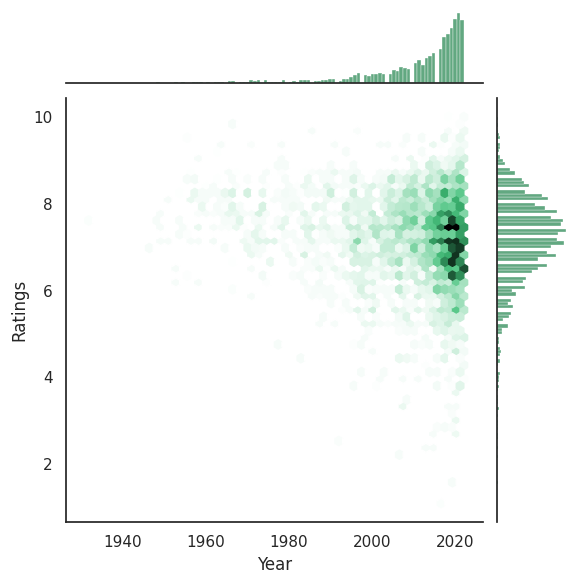

In [394]:
sns.jointplot(data=results, x="Year", y="Ratings", kind="hex", color='seagreen');

Honestly, I expected there to be a stronger relationship here. There is definitely a relationship here about the latest years beginning to fall though. If this was for some kind of report maybe it would be work breaking these into a *Ridge Plots* conditioned on the year.

## Violin Plot
*Violin Plots* are similar to Box and Whisker plots but they also add a visual element to show the distribution. We're going to check out whether a show being finished or not has an impact on the Ratings. 

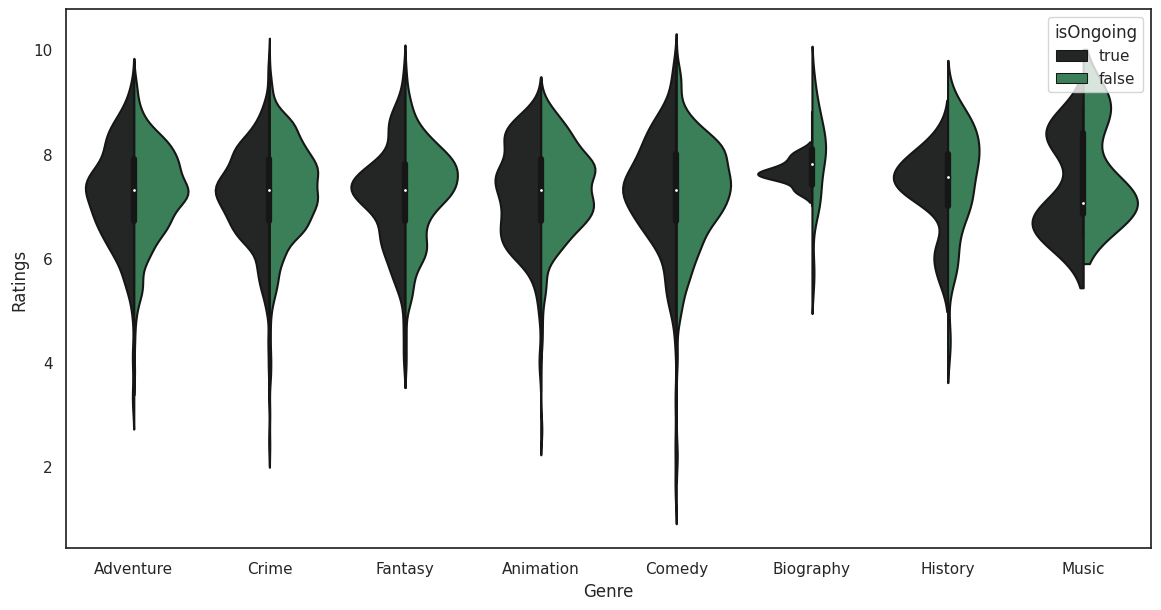

In [395]:
plt.rcParams["figure.figsize"] = (14,7)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'legend.facecolor':'white'})
pal = sns.dark_palette("seagreen", n_colors=2)

sns.violinplot(data=violinData, x="Genre", y="Ratings", split=True, hue="isOngoing", palette=pal);

There is something really strange going on with the **Biography** category. In a real analysis we'd want to dig into Biography to pull this apart more.

# Conclusions
We'll end this here. Hopefully this was an interesting to read over as it was to explore.